# Part 1: Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg
from psycopg.rows import dict_row

# Part 2: Grab Data from Database

In [2]:
user = "postgres"
password = "psql-password"
host = "127.0.0.1"
conn_string = "postgresql://{}:{}@{}:5432/house_price_prediction_service".format(user, password, host)

with psycopg.connect(conn_string, row_factory=dict_row) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT id, event_date, data FROM raw_home_sale_events;")
        
        # rows will be a list of dicts with the keys "id", "event_date", and "data"
        rows = cur.fetchall()

In [3]:
# Add all the ids to the inner data dictionaries and extract them
json_events = []
for row in rows:
    event = row["data"]
    event["id"] = row["id"]
    json_events.append(event)
    
df = pd.DataFrame.from_records(json_events)

# Part 3: Explore and Clean the Data

In [4]:
df = pd.read_csv('house_price_prediction_service.csv')

# Drop the Unnamed column
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# 1. Column descriptions
column_descriptions = {
    'id': 'Unique identifier for each house sale transaction',
    'date': 'Date when the house was sold',
    'price': 'Sale price of the house in dollars',
    'bedrooms': 'Number of bedrooms in the house',
    'bathrooms': 'Number of bathrooms in the house',
    'sqft_living': 'Total square footage of living space in the house',
    'sqft_lot': 'Total square footage of the lot',
    'floors': 'Number of floors in the house',
    'waterfront': 'Binary indicator if the house has a waterfront view',
    'view': 'Quality rating of the view from the house (0-4)',
    'condition': 'Overall condition rating of the house (1-5)',
    'grade': 'Construction and design grade (1-13)',
    'sqft_above': 'Square footage of house above ground',
    'sqft_basement': 'Square footage of basement',
    'yr_built': 'Year the house was built',
    'yr_renovated': 'Year of last renovation (0 if never renovated)',
    'zipcode': 'ZIP code location of the house',
    'lat': 'Latitude coordinate',
    'long': 'Longitude coordinate',
    'sqft_living15': 'Average living space for 15 nearest neighbors',
    'sqft_lot15': 'Average lot size for 15 nearest neighbors'
}

# 2. Column types
column_types = {
    'id': 'string',
    'date': 'datetime',
    'price': 'float',
    'bedrooms': 'int',
    'bathrooms': 'float',
    'sqft_living': 'int',
    'sqft_lot': 'int',
    'floors': 'float',
    'waterfront': 'boolean',
    'view': 'categorical',
    'condition': 'categorical',
    'grade': 'categorical',
    'sqft_above': 'int',
    'sqft_basement': 'int',
    'yr_built': 'int',
    'yr_renovated': 'int',
    'zipcode': 'string',
    'lat': 'float',
    'long': 'float',
    'sqft_living15': 'int',
    'sqft_lot15': 'int'
}

                lat          long          view         grade         price  \
count  37222.000000  37222.000000  37222.000000  37222.000000  3.722200e+04   
mean      47.560151   -122.214244      0.238972      7.634034  5.389410e+05   
std        0.139084      0.140092      0.774054      1.171205  3.674534e+05   
min       47.155900   -122.519000      0.000000      1.000000  7.500000e+04   
25%       47.468500   -122.327000      0.000000      7.000000  3.200000e+05   
50%       47.572700   -122.230000      0.000000      7.000000  4.500000e+05   
75%       47.678475   -122.126000      0.000000      8.000000  6.430000e+05   
max       47.777600   -121.315000      4.000000     13.000000  7.700000e+06   

             floors       zipcode      bedrooms      sqft_lot      yr_built  \
count  37222.000000  37222.000000  37222.000000  3.722200e+04  37222.000000   
mean       1.470112  98077.957848      3.369217  1.544873e+04   1969.484552   
std        0.528772     53.721691      0.933380  4.

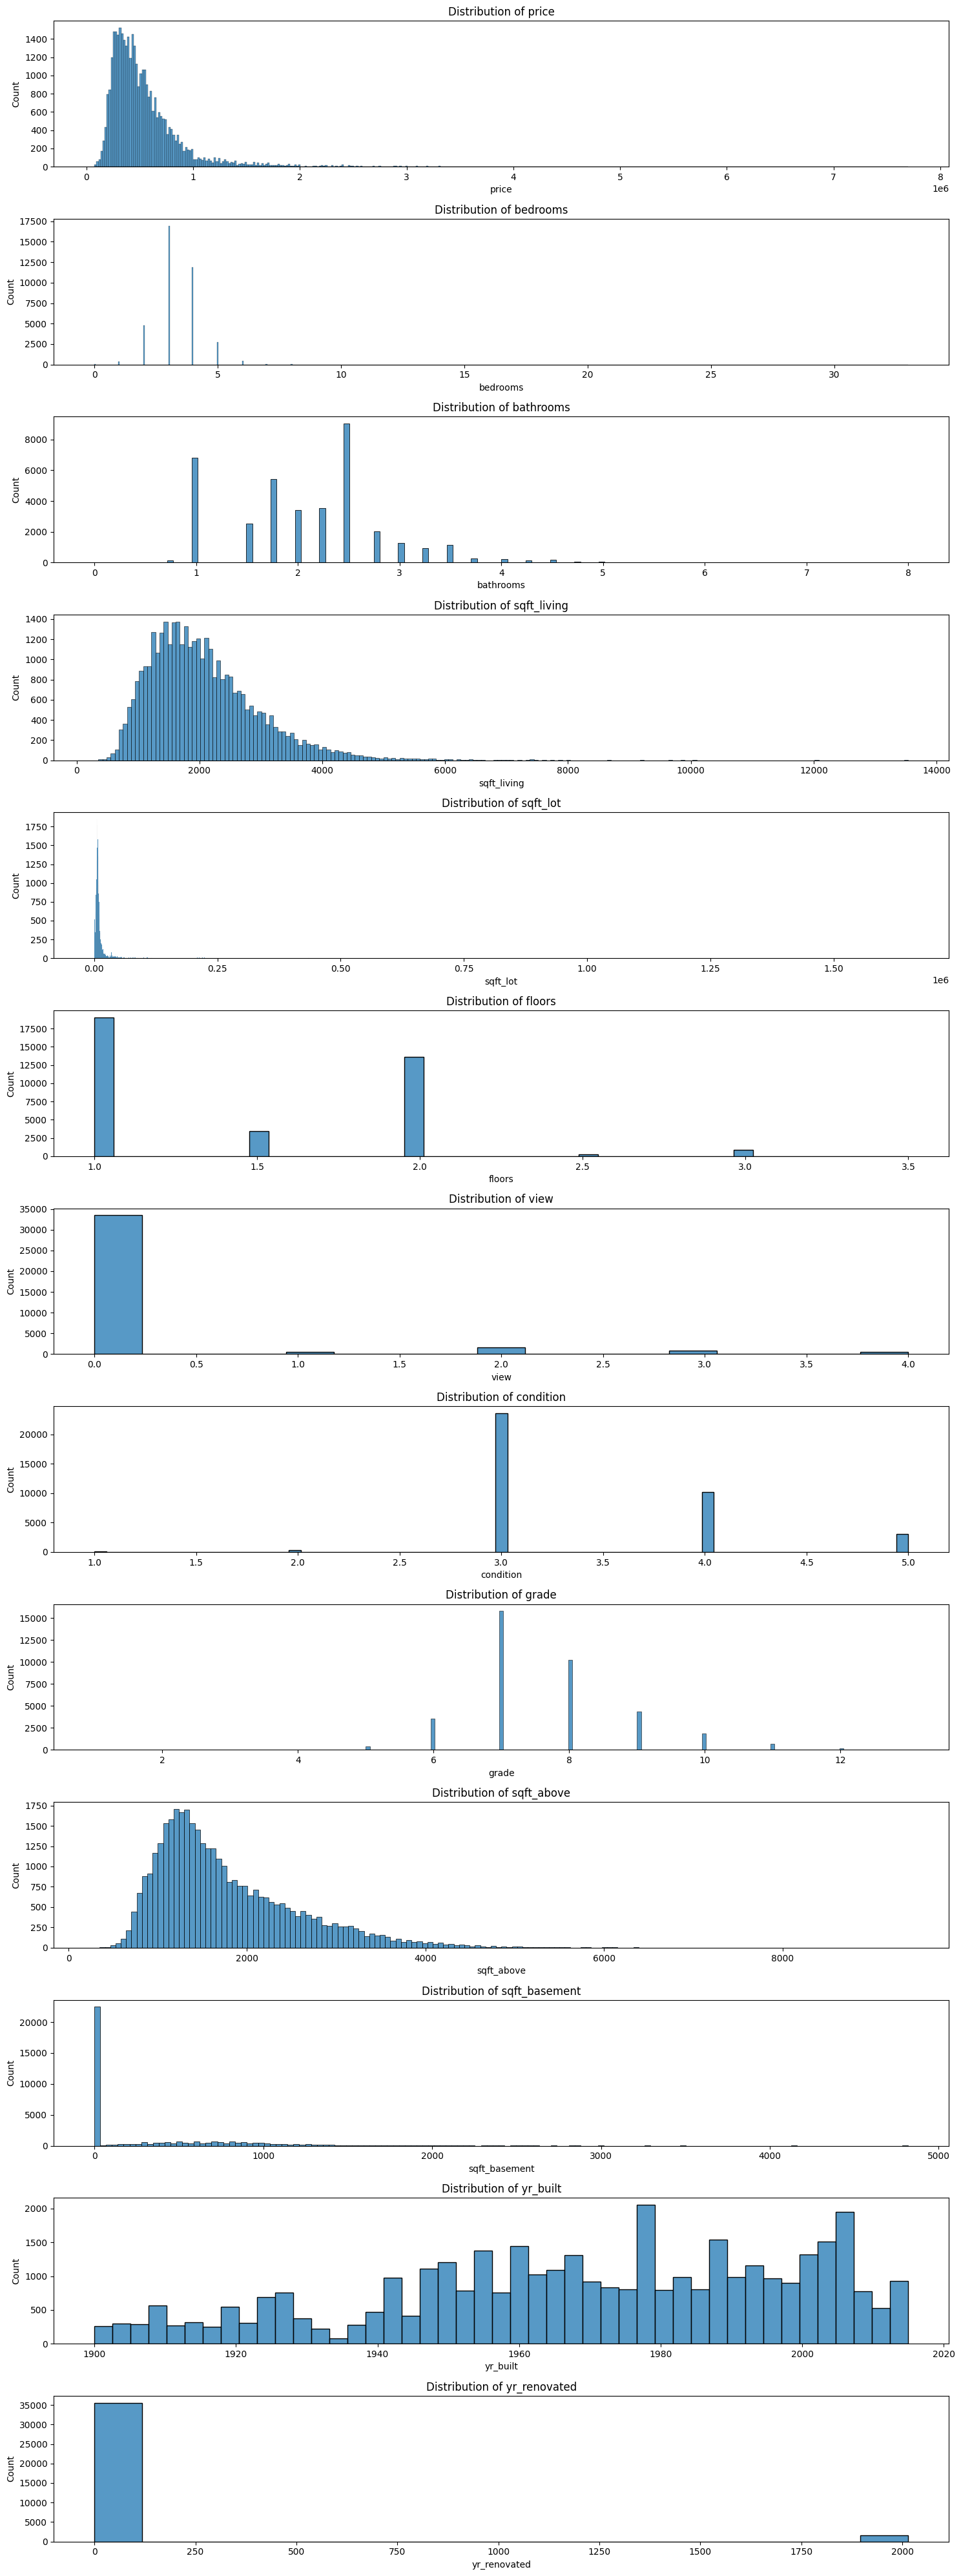

In [6]:
# 3. Examine numerical distributions
# Get basic statistics
print(df.describe())

# Create histogram plots for numerical columns
numerical_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                 'floors', 'view', 'condition', 'grade', 'sqft_above', 
                 'sqft_basement', 'yr_built', 'yr_renovated']

plt.figure(figsize=(15, 40))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.histplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [7]:
# 4. Identify unexpected values
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in numerical columns
for col in numerical_cols:
    print(f"\nOutliers in {col}:")
    outliers = find_outliers(df, col)
    if not outliers.empty:
        print(outliers[[col, 'price']].head())


Outliers in price:
         price      price
5    1225000.0  1225000.0
21   2000000.0  2000000.0
49   1350000.0  1350000.0
69   1325000.0  1325000.0
124  1450000.0  1450000.0

Outliers in bedrooms:
     bedrooms     price
153         1  350000.0
208         6  464000.0
231         6  315000.0
238         6  472000.0
263         1  369900.0

Outliers in bathrooms:
     bathrooms      price
5         4.50  1225000.0
269       4.75  1365000.0
299       5.00  3075000.0
414       4.25  1550000.0
445       4.50  1450000.0

Outliers in sqft_living:
     sqft_living      price
5           5420  1225000.0
41          4220   775000.0
70          4770  1040000.0
114         4380   740500.0
152         5180  2250000.0

Outliers in sqft_lot:
    sqft_lot      price
5     101930  1225000.0
12     19901   310000.0
21     44867  2000000.0
36     34848   550000.0
41     24186   775000.0

Outliers in floors:

Outliers in view:
    view      price
15     3   650000.0
21     4  2000000.0
49     2  135000

Numerical Columns Summary:
              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  3.722200e+04  37222.000000  37222.000000  37222.000000  3.722200e+04   
mean   5.389410e+05      3.369217      2.094843   2071.542744  1.544873e+04   
std    3.674534e+05      0.933380      0.765653    914.111485  4.189475e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.200000e+05      3.000000      1.500000   1420.000000  5.182750e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.719000e+03   
75%    6.430000e+05      4.000000      2.500000   2530.000000  1.083875e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  37222.000000  37222.000000  37222.000000  37222.000000  37222.000000   
mean       1.470112      0.007764      0.238972      3.427543      7.634034   
std        0.528772     

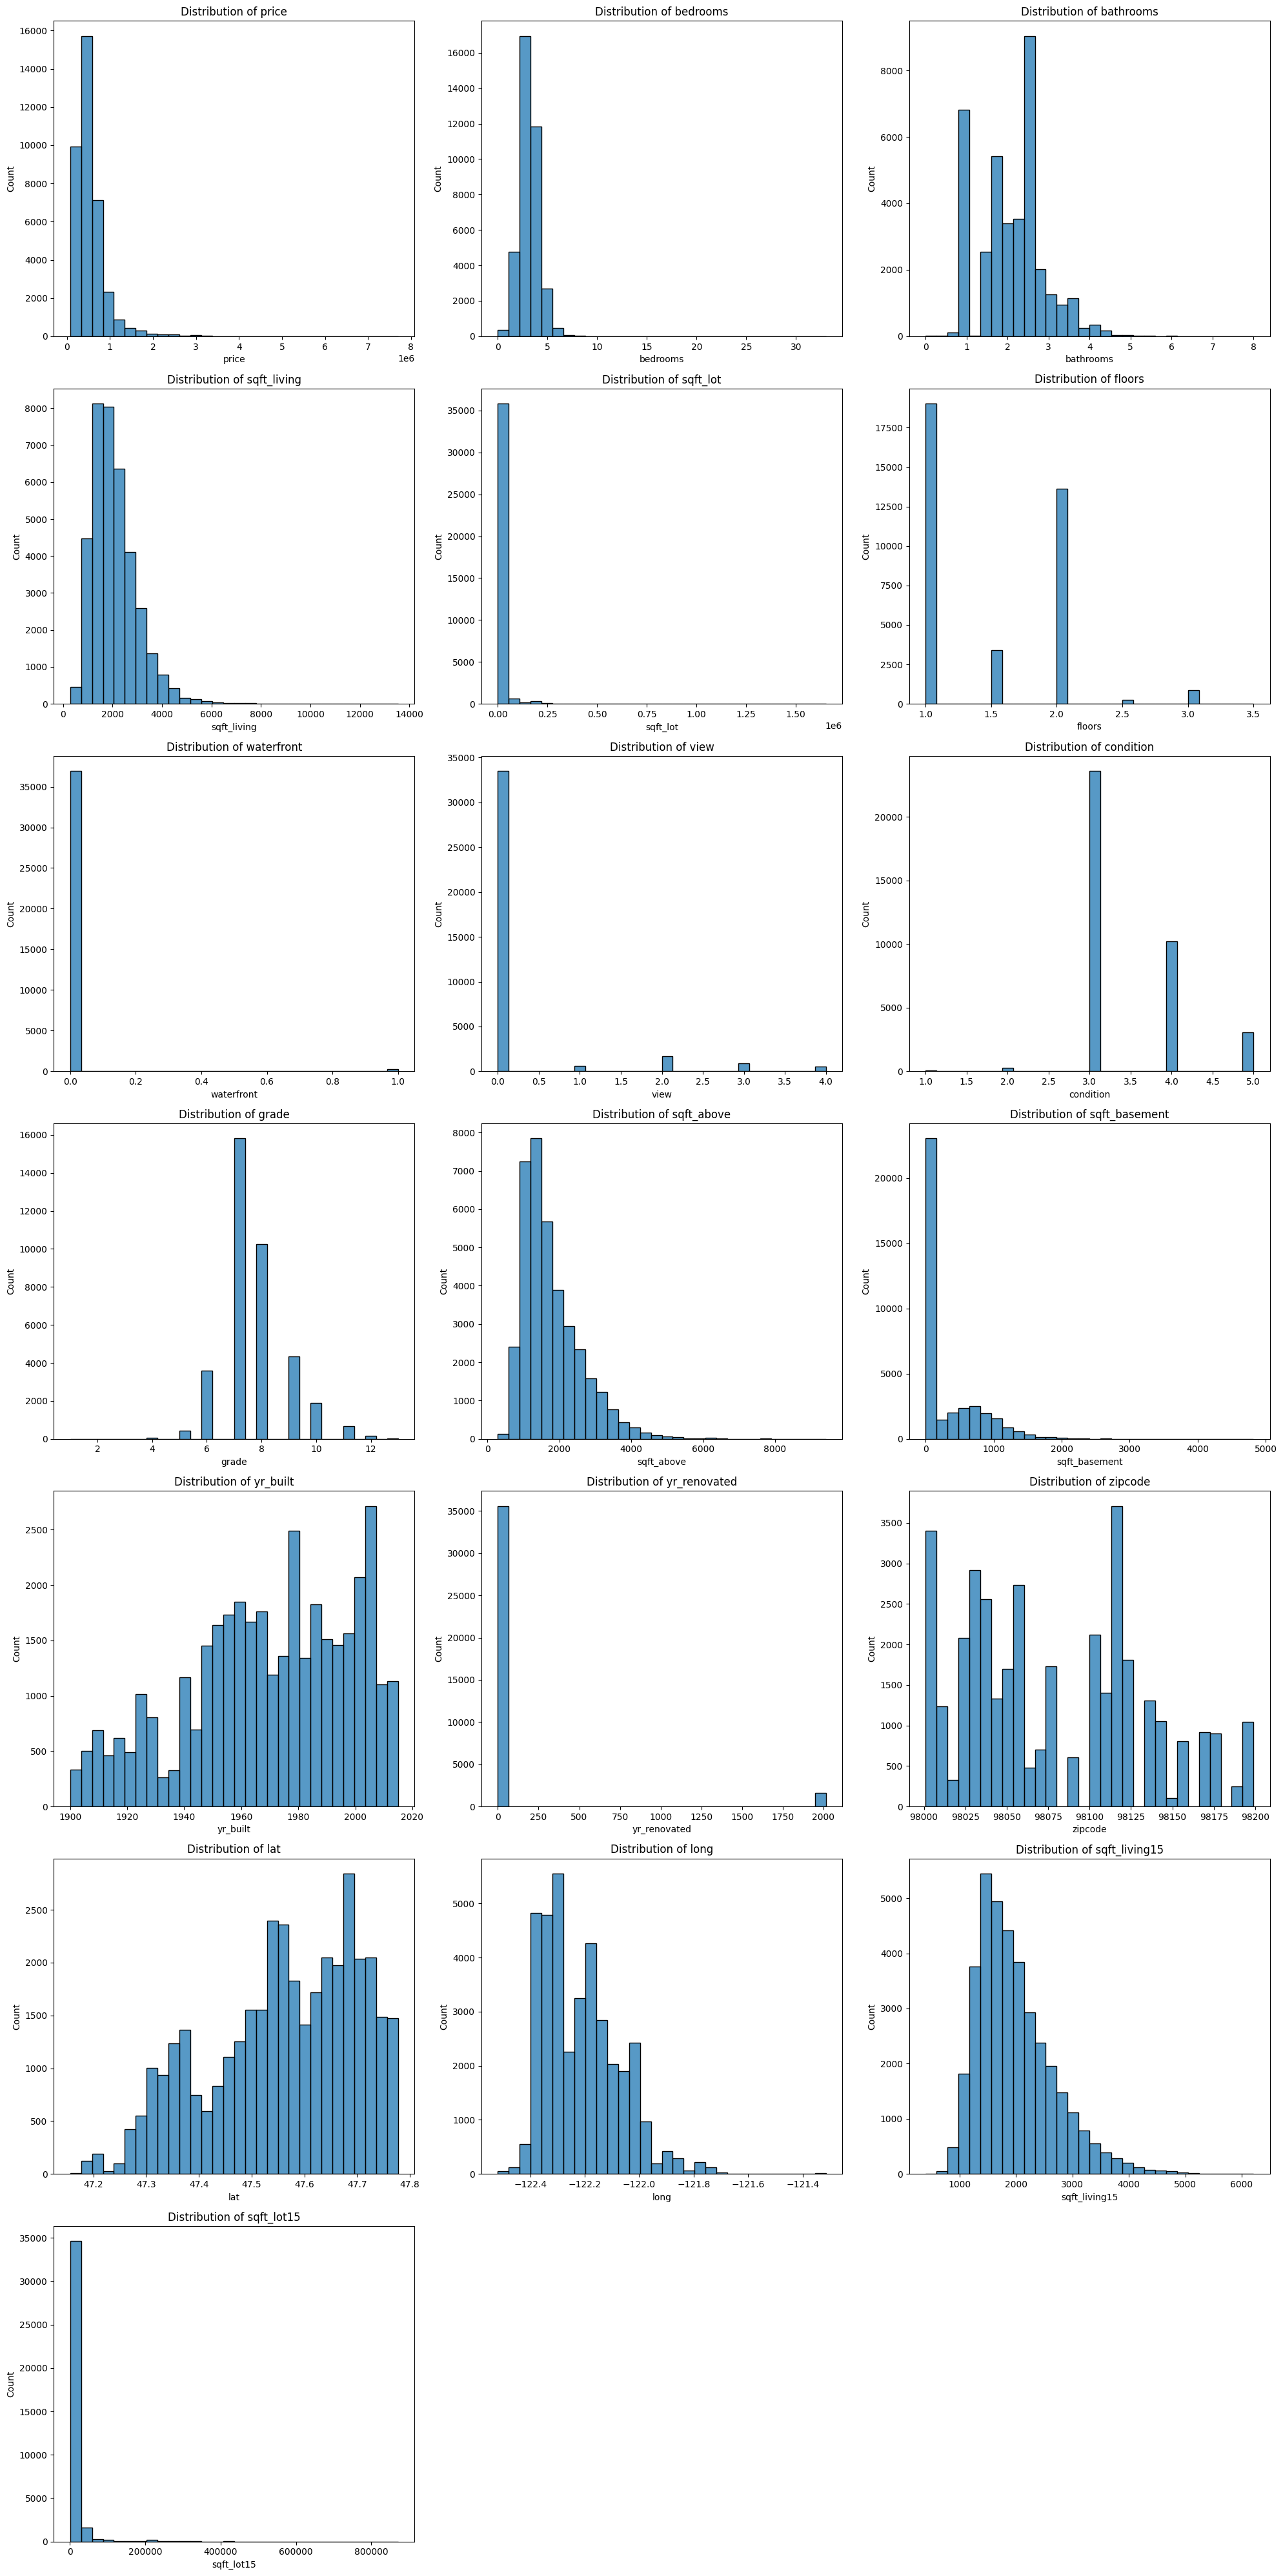


Detailed Range Analysis:

price:
Min: 75,000.00
Max: 7,700,000.00
Mean: 538,940.96
Median: 450,000.00
Number of zeros: 0
Number of unique values: 3,997
Number of outliers: 1,937 (5.20% of data)

bedrooms:
Min: 0.00
Max: 33.00
Mean: 3.37
Median: 3.00
Number of zeros: 24
Number of unique values: 13
Number of outliers: 952 (2.56% of data)

bathrooms:
Min: 0.00
Max: 8.00
Mean: 2.09
Median: 2.25
Number of zeros: 19
Number of unique values: 30
Number of outliers: 444 (1.19% of data)

sqft_living:
Min: 290.00
Max: 13,540.00
Mean: 2,071.54
Median: 1,910.00
Number of zeros: 0
Number of unique values: 1,038
Number of outliers: 1,008 (2.71% of data)

sqft_lot:
Min: 520.00
Max: 1,651,359.00
Mean: 15,448.73
Median: 7,719.00
Number of zeros: 0
Number of unique values: 9,782
Number of outliers: 4,281 (11.50% of data)

floors:
Min: 1.00
Max: 3.50
Mean: 1.47
Median: 1.00
Number of zeros: 0
Number of unique values: 6
Number of outliers: 0 (0.00% of data)

waterfront:
Min: 0.00
Max: 1.00
Mean: 0.01
Medi

In [8]:
# 5. Get range of values for each numerical column in df
# List of numerical columns (excluding id and date)
numerical_cols = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
    'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

# Get descriptive statistics for numerical columns
print("Numerical Columns Summary:")
print(df[numerical_cols].describe())
print("\n")

# Create histograms for each numerical column
plt.figure(figsize=(20, 40))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(7, 3, i)
    sns.histplot(data=df, x=col, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print detailed range information for each column
print("\nDetailed Range Analysis:")
for col in numerical_cols:
    print(f"\n{col}:")
    print(f"Min: {df[col].min():,.2f}")
    print(f"Max: {df[col].max():,.2f}")
    print(f"Mean: {df[col].mean():,.2f}")
    print(f"Median: {df[col].median():,.2f}")
    print(f"Number of zeros: {(df[col] == 0).sum():,}")
    print(f"Number of unique values: {df[col].nunique():,}")
    
    # Calculate outliers using IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers):,} ({(len(outliers)/len(df)*100):.2f}% of data)")

# Part 4: Prepare and Upload Complementary Data

In [9]:
rp_df = pd.read_csv('../Complementary Data/population_by_zip_2010.csv',
    usecols=['population', 'zipcode'],
    dtype={ 'zipcode' : str })

rs_df = pd.read_csv('../Complementary Data/Public_Schools.csv',
    usecols=['ZIP', 'LEVEL_'],
    dtype= { 'ZIP' : str })

In [10]:
# Group by ZIP and count the number of each school type
rs_df = rs_df.groupby(['ZIP', 'LEVEL_']).size().unstack(fill_value=0).reset_index()

# Rename columns to match PostgreSQL schema
rs_df.rename(columns={
    'ZIP': 'zipcode',
    'High': 'high_schools',
    'Middle': 'middle_schools',
    'Primary': 'primary_schools',
    'Other': 'other_schools',
    'Unknown': 'unknown_schools'
}, inplace=True)

# Ensure all expected columns exist (if some school types are missing)
expected_columns = ['zipcode', 'high_schools', 'middle_schools', 'primary_schools', 'other_schools', 'unknown_schools']
for col in expected_columns:
    if col not in rs_df.columns:
        rs_df[col] = 0  # Add missing school types with 0 count

# Add total number of schools per zipcode
rs_df['total_schools'] = rs_df[['high_schools', 'middle_schools', 'primary_schools', 'other_schools', 'unknown_schools']].sum(axis=1)
rp_df = rp_df.groupby('zipcode', as_index=False)['population'].sum()

In [11]:
rs_df.head() 

LEVEL_,zipcode,high_schools,middle_schools,other_schools,primary_schools,unknown_schools,total_schools
0,00601,0,2,0,7,0,9
1,00602,2,1,5,12,0,20
2,00603,1,4,1,10,0,16
3,00604,0,0,2,0,0,2
4,00605,2,0,0,6,0,8


In [12]:
rp_df.head()

,zipcode,population
0,00602,124560
1,00603,164067
2,00606,19845
3,00610,87048
4,00612,201030


In [13]:
# Insert rp_df into the database
with psycopg.connect(conn_string) as conn:
    with conn.cursor() as cur:
        for row in rp_df.to_dict(orient="records"):
            cur.execute("""INSERT INTO cleaned_zipcode_populations
                (zipcode, population)
                VALUES
                (%(zipcode)s, %(population)s);""",
                row)
        conn.commit()

In [14]:
# Insert rs_df into the database
with psycopg.connect(conn_string) as conn:
    with conn.cursor() as cur:
        for row in rs_df.to_dict(orient="records"):
            cur.execute("""
                INSERT INTO cleaned_zipcode_public_schools
                (zipcode, high_schools, middle_schools, primary_schools, other_schools, unknown_schools, total_schools)
                VALUES
                (%(zipcode)s, %(high_schools)s, %(middle_schools)s, %(primary_schools)s, %(other_schools)s, %(unknown_schools)s, %(total_schools)s);
            """, row)
        conn.commit()